C:\Users\Asus\AppData\Local\Temp\ipykernel_12472\3447218001.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')


Epoch 0 | Train loss: -0.69340 | Val loss: -0.69253 | Val recall@20: 0.01166 | Val ndcg@20: 0.00603
Epoch 5 | Train loss: -0.73008 | Val loss: -0.63769 | Val recall@20: 0.01706 | Val ndcg@20: 0.00836
Epoch 10 | Train loss: -0.86822 | Val loss: -0.43244 | Val recall@20: 0.01915 | Val ndcg@20: 0.00919
Epoch 15 | Train loss: -1.38898 | Val loss: -0.04438 | Val recall@20: 0.02008 | Val ndcg@20: 0.00969
Epoch 20 | Train loss: -2.09885 | Val loss: 0.49915 | Val recall@20: 0.01945 | Val ndcg@20: 0.00963
Epoch 25 | Train loss: -3.33738 | Val loss: 1.15953 | Val recall@20: 0.01980 | Val ndcg@20: 0.00982
Epoch 30 | Train loss: -4.44993 | Val loss: 1.92879 | Val recall@20: 0.01962 | Val ndcg@20: 0.00977
Test loss: 1.90140 | Test recall@20: 0.01761 | Test ndcg@20: 0.00918


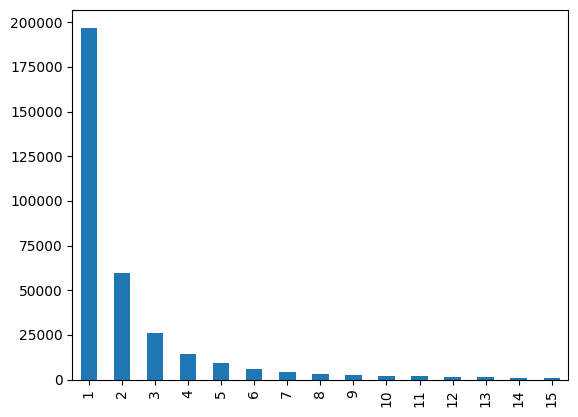

In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv
import tqdm as notebook_tqdm


df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')

isbn_counts = df.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')


userid_counts = df.groupby('User-ID').size() 
count_occurrences = userid_counts.value_counts() 
count_occurrences[:15].plot(kind='bar')




# Preprocessing
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
df = df[df['Book-Rating'] >= 8].iloc[:100000]

# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

Favorite books from user n°277427:
- The Da Vinci Code, by Dan Brown
- Into the Wild, by Jon Krakauer
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich

Recommended books for user n°277427
- The Lovely Bones: A Novel, by Alice Sebold
- The Red Tent (Bestselling Backlist), by Anita Diamant
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- To Kill a Mockingbird, by Harper Lee
- Angels &amp; Demons, by Dan Brown


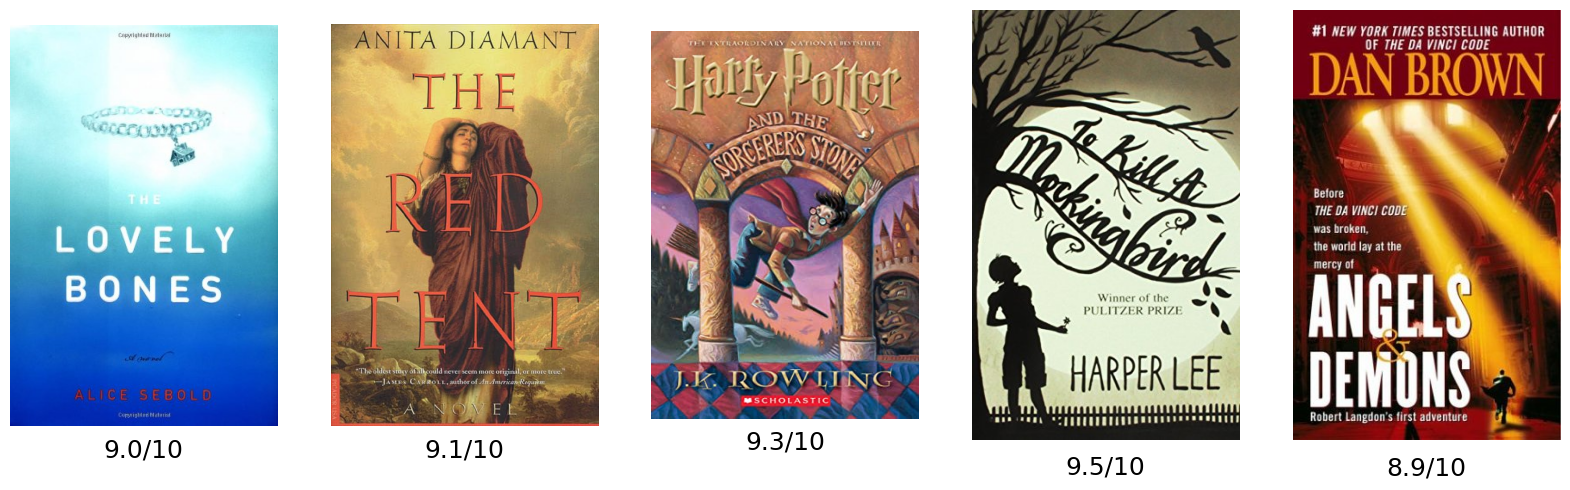

In [5]:
recommend(277427, 5)